In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D,BatchNormalization,Cropping2D
from tensorflow.keras.models import Model
import random
import tensorflow as tf
from tensorflow.keras import backend as K

2025-07-03 06:47:23.095783: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751525243.303725      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751525243.361759      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
# Đọc tệp Excel vào DataFrame
file_path = "/kaggle/input/daaset/data/classification.xlsx"  # Đường dẫn đến file Excel
df = pd.read_excel(file_path)

# Đường dẫn thư mục ảnh và mask
image_path = '/kaggle/input/daaset/data/images'
mask_path = '/kaggle/input/daaset/data/masks'
print("a1")

a1


In [6]:
!pip install openpyxl


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [7]:
from sklearn.model_selection import train_test_split

# Lọc những ảnh có mask
df_with_mask = df[df['mask_flag'] == 1].copy()

# Chia Train (70%) và temp (30%)
df_train, df_temp = train_test_split(df_with_mask, test_size=0.3, random_state=42, shuffle=True)

# Chia temp thành Validation (15%) và Test (15%)
df_valid, df_test = train_test_split(df_temp, test_size=0.5, random_state=42, shuffle=True)

# Kiểm tra số lượng
print("Train:", len(df_train), "Validation:", len(df_valid), "Test:", len(df_test))


Train: 1306 Validation: 280 Test: 281


In [8]:
# Tạo cột đường dẫn
df_train['image_path'] = df_train['image_id'].apply(lambda x: os.path.join(image_path, f"{os.path.splitext(x)[0]}.jpg"))
df_train['mask_path']  = df_train['image_id'].apply(lambda x: os.path.join(mask_path, f"{os.path.splitext(x)[0]}.png"))

df_test['image_path'] = df_test['image_id'].apply(lambda x: os.path.join(image_path, f"{os.path.splitext(x)[0]}.jpg"))
df_test['mask_path']  = df_test['image_id'].apply(lambda x: os.path.join(mask_path, f"{os.path.splitext(x)[0]}.png"))

df_valid['image_path'] = df_valid['image_id'].apply(lambda x: os.path.join(image_path, f"{os.path.splitext(x)[0]}.jpg"))
df_valid['mask_path']  = df_valid['image_id'].apply(lambda x: os.path.join(mask_path, f"{os.path.splitext(x)[0]}.png"))

print("a1")

a1


In [9]:
import tensorflow as tf
import random

# Hàm load ảnh và mask (bỏ comment, dùng bình thường)
def load_image_and_mask(image_path, mask_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=1)
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32) / 255.0

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, [224, 224], method='nearest')
    mask = tf.cast(mask > 0, tf.uint8)  # <- Rất quan trọng: đưa mọi giá trị khác 0 về 1
    mask = tf.squeeze(mask, axis=-1)
    mask = tf.one_hot(mask, depth=2)

    return image, mask

    
def random_augment(image, mask):
    # Lật ngang
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)

    # Dịch chuyển
    if tf.random.uniform(()) > 0.5:
        shift = tf.random.uniform(shape=[2], minval=-10, maxval=10, dtype=tf.int32)
        image = tf.roll(image, shift=shift, axis=[0, 1])
        mask = tf.roll(mask, shift=shift, axis=[0, 1])

    return image, mask

# Hàm load với augment cho train dataset
def load_image_and_mask_with_aug(image_path, mask_path):
    image, mask = load_image_and_mask(image_path, mask_path)

    # Gọi augment bên ngoài
    image, mask = random_augment(image, mask)

    # Có thể thêm augment riêng cho ảnh ở đây
    if tf.random.uniform(()) > 0.5:
        image = tf.image.random_brightness(image, 0.1)
    if tf.random.uniform(()) > 0.5:
        image = tf.image.random_contrast(image, 0.8, 1.2)

    return image, mask


# Chọn batch size cố định hoặc random
BATCH_SIZE = 8  # hoặc random.choice([8]) nếu muốn random

# Tạo dataset train có augment, chỉ khi df_train không rỗng
if not df_train.empty:
    train_dataset = tf.data.Dataset.from_tensor_slices((df_train['image_path'], df_train['mask_path']))
    train_dataset = train_dataset.map(load_image_and_mask_with_aug, num_parallel_calls=tf.data.AUTOTUNE)
    train_dataset = train_dataset.shuffle(buffer_size=1000)
    train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
else:
    print("⚠️ df_train is empty. Skipping train_dataset creation.")
    train_dataset = None

# Dataset validation (không augment)
if not df_valid.empty:
    val_dataset = tf.data.Dataset.from_tensor_slices((df_valid['image_path'], df_valid['mask_path']))
    val_dataset = val_dataset.map(load_image_and_mask, num_parallel_calls=tf.data.AUTOTUNE)
    val_dataset = val_dataset.batch(16).prefetch(tf.data.AUTOTUNE)
else:
    print("⚠️ df_valid is empty. Skipping val_dataset creation.")
    val_dataset = None

# Dataset test (không augment)
if not df_test.empty:
    test_dataset = tf.data.Dataset.from_tensor_slices((df_test['image_path'], df_test['mask_path']))
    test_dataset = test_dataset.map(load_image_and_mask, num_parallel_calls=tf.data.AUTOTUNE)
    test_dataset = test_dataset.batch(16).prefetch(tf.data.AUTOTUNE)
else:
    print("⚠️ df_test is empty. Skipping test_dataset creation.")
    test_dataset = None

print("Datasets prepared.")


I0000 00:00:1749627303.028583      10 service.cc:148] XLA service 0x59331d339bc0 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749627303.028631      10 service.cc:156]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1749627303.028635      10 service.cc:156]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1749627303.028638      10 service.cc:156]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1749627303.028646      10 service.cc:156]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1749627303.028649      10 service.cc:156]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1749627303.028651      10 service.cc:156]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1749627303.028654      10 service.cc:156]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1749627303.028657      10 service.cc:156]   StreamExecutor device (7): TPU, 2a886c8


Datasets prepared.


Train batch shape:
Image batch shape: (8, 224, 224, 1)
Mask batch shape: (8, 224, 224, 2)


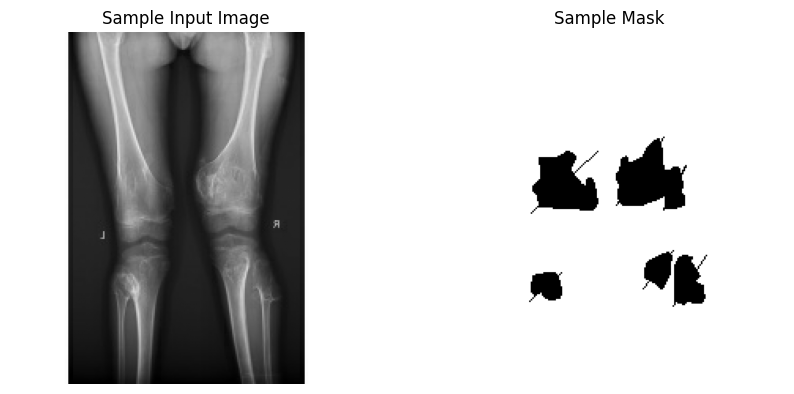

Validation batch shape:
Image batch shape: (16, 224, 224, 1)
Mask batch shape: (16, 224, 224, 2)


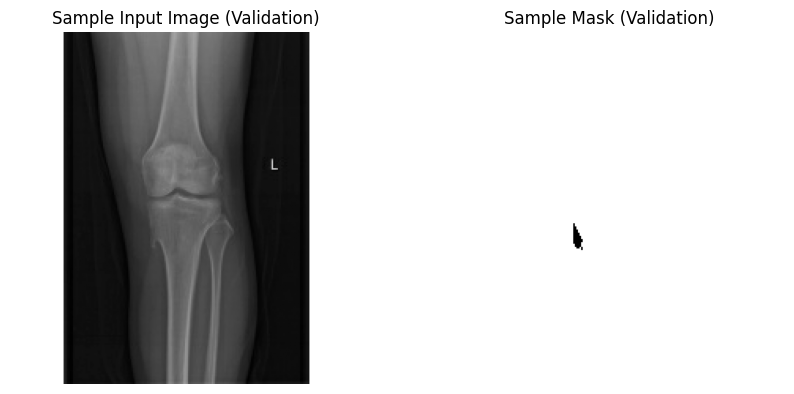

Test batch shape:
Image batch shape: (16, 224, 224, 1)
Mask batch shape: (16, 224, 224, 2)


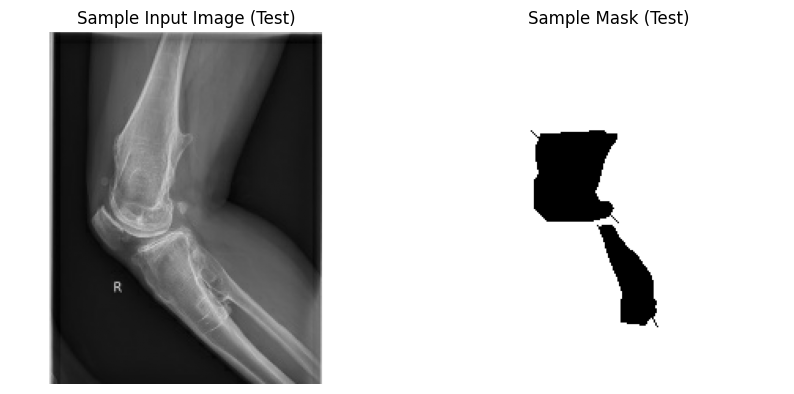

a1


In [10]:
import matplotlib.pyplot as plt

# Kiểm tra một batch từ train_dataset
for images, masks in train_dataset.take(1):  # Lấy 1 batch từ train_dataset
    print("Train batch shape:")
    print("Image batch shape:", images.shape)  # Kích thước của batch ảnh
    print("Mask batch shape:", masks.shape)    # Kích thước của batch mask

    # Hiển thị một ảnh và mask
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(images[0, :, :, 0], cmap='gray')  # Hiển thị ảnh đầu tiên trong batch (1 channel)
    plt.title("Sample Input Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(masks[0, :, :, 0], cmap='gray')  # Hiển thị mask đầu tiên trong batch (1 channel)
    plt.title("Sample Mask")
    plt.axis('off')

    plt.show()
    break  # Dừng sau khi đã kiểm tra 1 batch

# Kiểm tra một batch từ val_dataset
for images, masks in val_dataset.take(1):
    print("Validation batch shape:")
    print("Image batch shape:", images.shape)
    print("Mask batch shape:", masks.shape)

    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(images[0, :, :, 0], cmap='gray')
    plt.title("Sample Input Image (Validation)")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(masks[0, :, :, 0], cmap='gray')
    plt.title("Sample Mask (Validation)")
    plt.axis('off')

    plt.show()
    break

# Kiểm tra một batch từ test_dataset
for images, masks in test_dataset.take(1):
    print("Test batch shape:")
    print("Image batch shape:", images.shape)
    print("Mask batch shape:", masks.shape)

    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(images[0, :, :, 0], cmap='gray')
    plt.title("Sample Input Image (Test)")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(masks[0, :, :, 0], cmap='gray')
    plt.title("Sample Mask (Test)")
    plt.axis('off')

    plt.show()
    break
print("a1")

In [11]:
from tensorflow.keras.layers import Dropout
def segnet(input_shape=(224, 224, 1), num_classes=2):
    inputs = Input(shape=input_shape)

    # Encoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)  # 112x112

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)  # 56x56

    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)  # 28x28

    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)  # 14x14

    # Decoder
    x = UpSampling2D((2, 2))(x)  # 28x28
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = UpSampling2D((2, 2))(x)  # 56x56
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = UpSampling2D((2, 2))(x)  # 112x112
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = UpSampling2D((2, 2))(x)  # 224x224
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    # Output
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

# Gọi model
model = segnet(input_shape=(224, 224, 1), num_classes=2)

def weighted_dice_loss(y_true, y_pred, class_weights=[0.2, 0.8]):
    smooth = 1e-6
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    dice = 0
    for i in range(len(class_weights)):
        y_true_f = K.flatten(y_true[..., i])
        y_pred_f = K.flatten(y_pred[..., i])
        intersection = K.sum(y_true_f * y_pred_f)
        union = K.sum(y_true_f) + K.sum(y_pred_f)
        dice_score = (2. * intersection + smooth) / (union + smooth)
        dice += class_weights[i] * (1 - dice_score)  # Weighted Dice Loss

    return dice
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.round(y_pred)
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred)
    return (2. * intersection + smooth) / (union + smooth)


model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-5),
    loss=weighted_dice_loss,  # use the new weighted loss
    metrics=[
        dice_coef,
        tf.keras.metrics.MeanIoU(num_classes=2),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall()
    ]
)



In [12]:
# Đếm số pixel mỗi lớp trong mỗi tập (sau one-hot)
def count_class_pixels(dataset):
    class_counts = [0, 0]
    for _, mask in dataset.take(50):  # kiểm tra một vài batch
        summed = tf.reduce_sum(mask, axis=[0, 1, 2])
        class_counts[0] += summed[0].numpy()
        class_counts[1] += summed[1].numpy()
    return class_counts

print("Train class distribution:", count_class_pixels(train_dataset))
print("Val class distribution:", count_class_pixels(val_dataset))
print("Test class distribution:", count_class_pixels(test_dataset))


Train class distribution: [np.float32(19720084.0), np.float32(350317.0)]
Val class distribution: [np.float32(13814631.0), np.float32(234649.0)]
Test class distribution: [np.float32(13818453.0), np.float32(281003.0)]


In [13]:

epochs = 300

history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    verbose=1
)

print("✅ Quá trình huấn luyện hoàn tất!")


Epoch 1/300


NotFoundError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/usr/local/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/local/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/usr/local/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/usr/local/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 765, in start

  File "/usr/local/lib/python3.10/site-packages/anyio/_core/_eventloop.py", line 74, in run

  File "/usr/local/lib/python3.10/site-packages/anyio/_backends/_asyncio.py", line 2310, in run

  File "/usr/local/lib/python3.10/site-packages/anyio/_backends/_asyncio.py", line 217, in run

  File "/usr/local/lib/python3.10/asyncio/base_events.py", line 636, in run_until_complete

  File "/usr/local/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/local/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/local/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 435, in process_shell

  File "/usr/local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 512, in process_shell_message

  File "/usr/local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 361, in execute_request

  File "/usr/local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 766, in execute_request

  File "/usr/local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 457, in do_execute

  File "/usr/local/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 606, in run_cell

  File "/usr/local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3077, in run_cell

  File "/usr/local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3132, in _run_cell

  File "/usr/local/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3336, in run_cell_async

  File "/usr/local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3519, in run_ast_nodes

  File "/usr/local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3579, in run_code

  File "/tmp/ipykernel_10/848322353.py", line 3, in <module>

  File "/usr/local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit

  File "/usr/local/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/usr/local/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

could not find registered transfer manager for platform Host -- check target linkage
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_multi_step_on_iterator_17271]

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

results = model.evaluate(test_dataset)
print(f"Results: {results}")


In [ ]:
model.save('n1.h5')
model.save('/kaggle/working//n1.h5') 

In [ ]:
import tensorflow as tf

def dice_score(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
# Evaluate model on test dataset
predictions = model.predict(test_dataset)

# Flatten predicted masks and ground truths
y_true = []
y_pred = []

for batch in test_dataset:
    images, masks = batch
    preds = model.predict(images)
    y_true.append(masks)
    y_pred.append(preds)

# Gộp lại tất cả các batch
y_true = tf.concat(y_true, axis=0)
y_pred = tf.concat(y_pred, axis=0)

# Binarize prediction nếu là ảnh nhị phân
y_pred = tf.cast(y_pred > 0.5, tf.float32)

# Tính Dice Score
dice = dice_score(y_true, y_pred)
print(f"Dice Score: {dice.numpy():.4f}")
